In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
import nltk
from nltk.corpus import wordnet as wn

In [2]:
# I really don't like the eval calls.
# I'll use sed to convert the file to a raw list of words.

with open('../data/wordle_words.txt') as file:
    solution_words = eval(file.readline())
    other_words = eval(file.readline())

In [3]:
len(solution_words), len(other_words)

(2315, 10657)

In [4]:
all_words = solution_words + other_words
len(all_words)

12972

In [5]:
words = pd.DataFrame(index=all_words)

words['valid'] = True
words['valid'] = words.where(words.loc[solution_words], False)

In [6]:
words.valid.value_counts()

False    10657
True      2315
Name: valid, dtype: int64

In [7]:
for position in range(1, 6):
    letters = words.index.str[position - 1]
    words[position] = letters
    
words.head()

,valid,1,2,3,4,5
cigar,True,c,i,g,a,r
rebut,True,r,e,b,u,t
sissy,True,s,i,s,s,y
humph,True,h,u,m,p,h
awake,True,a,w,a,k,e


In [8]:
for letter in string.ascii_lowercase:
    words[letter] = 0
    
words.head()

,valid,1,2,3,4,5,a,b,c,d,...,q,r,s,t,u,v,w,x,y,z
cigar,True,c,i,g,a,r,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rebut,True,r,e,b,u,t,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sissy,True,s,i,s,s,y,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
humph,True,h,u,m,p,h,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
awake,True,a,w,a,k,e,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for position in range(1, 6):
    for letter in string.ascii_lowercase:
        words[letter] += words[position] == letter
        
words.head()

,valid,1,2,3,4,5,a,b,c,d,...,q,r,s,t,u,v,w,x,y,z
cigar,True,c,i,g,a,r,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
rebut,True,r,e,b,u,t,0,1,0,0,...,0,1,0,1,1,0,0,0,0,0
sissy,True,s,i,s,s,y,0,0,0,0,...,0,0,3,0,0,0,0,0,1,0
humph,True,h,u,m,p,h,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
awake,True,a,w,a,k,e,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
words = pd.concat([words, pd.get_dummies(words[[1, 2, 3, 4, 5]], prefix_sep='')], axis=1)
words.head()

,valid,1,2,3,4,5,a,b,c,d,...,5q,5r,5s,5t,5u,5v,5w,5x,5y,5z
cigar,True,c,i,g,a,r,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
rebut,True,r,e,b,u,t,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
sissy,True,s,i,s,s,y,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
humph,True,h,u,m,p,h,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
awake,True,a,w,a,k,e,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# The letter dictionary measures the frequency at which each letter appears in the entire set of 5 letter words.

valid_words = words[words['valid']]

total_letters = valid_words.shape[0] * 5

letter_dict = {}
for letter in string.ascii_lowercase:
    letter_dict[letter] = valid_words[letter].sum() / total_letters * 100

sorted(letter_dict.items(), key=lambda x: x[1], reverse=True)

[('e', 10.652267818574513),
 ('a', 8.457883369330453),
 ('r', 7.766738660907127),
 ('o', 6.514038876889849),
 ('t', 6.298056155507559),
 ('l', 6.211663066954644),
 ('i', 5.796976241900648),
 ('s', 5.779697624190065),
 ('n', 4.967602591792657),
 ('c', 4.120950323974082),
 ('u', 4.0345572354211665),
 ('y', 3.6717062634989204),
 ('d', 3.3952483801295896),
 ('h', 3.3606911447084236),
 ('p', 3.170626349892008),
 ('m', 2.7300215982721383),
 ('g', 2.6868250539956806),
 ('b', 2.427645788336933),
 ('f', 1.9870410367170626),
 ('k', 1.8142548596112311),
 ('w', 1.6846652267818574),
 ('v', 1.3218142548596112),
 ('z', 0.34557235421166305),
 ('x', 0.31965442764578833),
 ('q', 0.2505399568034557),
 ('j', 0.23326133909287258)]

In [12]:
# The position dictionary measures the frequency each letter appears in each individual letter position
# For example, the value for '5s' will be the frequency that the letter s appears in the 5th position.

total_words = valid_words.shape[0]

position_dict = {}
for position in range(1, 6):
    for letter in string.ascii_lowercase:
        key = f'{position}{letter}'
        position_dict[key] = valid_words[key].sum() / total_words * 100
        
sorted(position_dict.items(), key=lambda x: x[1], reverse=True)

[('5e', 18.315334773218144),
 ('1s', 15.809935205183583),
 ('5y', 15.72354211663067),
 ('4e', 13.736501079913607),
 ('3a', 13.261339092872571),
 ('2a', 13.131749460043196),
 ('2o', 12.051835853131749),
 ('2r', 11.533477321814255),
 ('3i', 11.490280777537796),
 ('5t', 10.928725701943845),
 ('3o', 10.539956803455723),
 ('2e', 10.453563714902808),
 ('5r', 9.157667386609072),
 ('2i', 8.725701943844493),
 ('2l', 8.682505399568035),
 ('1c', 8.55291576673866),
 ('2u', 8.034557235421167),
 ('4n', 7.861771058315335),
 ('3e', 7.645788336933046),
 ('1b', 7.473002159827214),
 ('4s', 7.386609071274298),
 ('3u', 7.127429805615551),
 ('3r', 7.041036717062635),
 ('4a', 7.041036717062635),
 ('4l', 6.9978401727861765),
 ('4i', 6.825053995680346),
 ('5l', 6.7386609071274295),
 ('4c', 6.565874730021598),
 ('4r', 6.565874730021598),
 ('1t', 6.436285097192225),
 ('2h', 6.220302375809935),
 ('1p', 6.133909287257019),
 ('1a', 6.090712742980561),
 ('3n', 6.004319654427646),
 ('4t', 6.004319654427646),
 ('5h', 

In [13]:
words['letter_score'] = 0

for letter in string.ascii_lowercase:
    words['letter_score'] += words[letter].astype('bool') * letter_dict[letter]
    
words['letter_score'].describe()

count    12972.000000
mean        25.768825
std          5.226409
min          8.846652
25%         22.211663
50%         25.935205
75%         29.529158
max         39.688985
Name: letter_score, dtype: float64

In [14]:
words['position_score'] = 0

for position in range(1, 6):
    for letter in string.ascii_lowercase:
        column = f'{position}{letter}'
        words['position_score'] += words[column].astype('bool') * position_dict[column]
        
words['position_score'].describe()

count    12972.000000
mean        34.859391
std          9.107554
min          8.250540
25%         28.250540
50%         34.427646
75%         41.036717
max         68.034557
Name: position_score, dtype: float64

In [15]:
words['tiebreaker'] = words['letter_score'] + words['position_score']

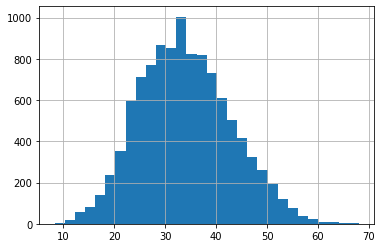

In [16]:
_ = words[words['valid'] == False].position_score.hist(bins=30)

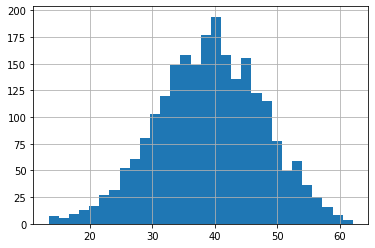

In [17]:
_ = words[words['valid'] == True].position_score.hist(bins=30)

In [18]:
words.sort_values('tiebreaker', ascending=False)

,valid,1,2,3,4,5,a,b,c,d,...,5t,5u,5v,5w,5x,5y,5z,letter_score,position_score,tiebreaker
soare,False,s,o,a,r,e,1,0,0,0,...,0,0,0,0,0,0,0,39.170626,66.004320,105.174946
saine,False,s,a,i,n,e,1,0,0,0,...,0,0,0,0,0,0,0,35.654428,66.609071,102.263499
saree,False,s,a,r,e,e,1,0,0,0,...,0,0,0,0,0,0,0,32.656587,68.034557,100.691145
saice,False,s,a,i,c,e,1,0,1,0,...,0,0,0,0,0,0,0,34.807775,65.313175,100.120950
slane,False,s,l,a,n,e,1,0,0,0,...,0,0,0,0,0,0,0,36.069114,63.930886,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kibbi,False,k,i,b,b,i,0,2,0,0,...,0,0,0,0,0,0,0,10.038877,13.563715,23.602592
xylyl,False,x,y,l,y,l,0,0,0,0,...,0,0,0,0,0,0,0,10.203024,12.699784,22.902808
kudzu,False,k,u,d,z,u,0,0,0,1,...,0,1,0,0,0,0,0,9.589633,13.045356,22.634989
oxbow,False,o,x,b,o,w,0,1,0,0,...,0,0,0,1,0,0,0,10.946004,11.274298,22.220302


In [19]:
with open('../data/letter_dict.pkl', 'wb') as file:
    pickle.dump(letter_dict, file)

In [20]:
with open('../data/position_dict.pkl', 'wb') as file:
    pickle.dump(position_dict, file)

In [21]:
words.to_pickle('../data/words.pkl')